# Inferring cosmology power spectrum parameters from 2D fields
(by Lucas Makinen and Tom Charnock)

A useful example to consider is the inference of the parameter values controlling the shape of the power spectrum used to generate 2D Gaussian random fields. This is interesting because we can analytically calculate the Fisher information to check our convergence and it has aspects which are very similar to cosmological field analysis. This example is split into two parts, first the analytic comparison when the power spectrum is of the form 
$$P(k) = Ak^{-B}$$
and a second part where we use a jax implementation of a cosmology library (`pip install jax-cosmo`) to infer cosmological parameters from 2D Gaussian random fields. 

In this example we will also show how inception blocks can be implemented in a stax-like neural model.

## Power law example - $P(k) = Ak^{-B}$

The likelihood for an $N_{\rm pix}\times N_{\rm pix}$ Gaussian field, $\boldsymbol{\delta}$, can be explicitly written down for the Fourier transformed data, $\boldsymbol{\Delta}$ as
$$\mathcal{L}(\boldsymbol{\Delta}|\boldsymbol{\theta}) = \frac{1}{(2\pi)^{N_{\rm pix}^2 / 2} |P({\bf k}, \boldsymbol{\theta})|^{1/2}}\exp{\left(-\frac{1}{2}\boldsymbol{\Delta}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\boldsymbol{\Delta}\right)}$$
Since the Fisher information can be calculated from the expectation value of the second derivative of the score, i.e. the log likelihood
$${\bf F}_{\alpha\beta} = - \left.\left\langle\frac{\partial^2\ln\mathcal{L}(\Delta|\boldsymbol{\theta})}{\partial\theta_\alpha\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}=\boldsymbol{\theta}^\textrm{fid}}$$
Then we know that analytically the Fisher information must be
$${\bf F}_{\alpha\beta} = \frac{1}{2} {\rm Tr} \left(\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial\theta_\alpha}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial\theta_\beta}\left(P({\bf k}, \boldsymbol{\theta})\right)^{-1}\right)$$
where $\alpha$ and $\beta$ label the parameters $A$ and $B$ in the power spectrum. As each $k$-mode is uncoupled for this power law form then the derivatives  are
$$\begin{align}
\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial A} = &~k^{-B}\\
\frac{\partial P({\bf k}, \boldsymbol{\theta})}{\partial B} = & -Ak^{-B}\ln k.\\
\end{align}$$
We can set up these functions. Note that for large fields there can be an issue with numerical overflow and as such we will use jax in 64 bit mode.

In [14]:
cd ~/repositories/scratch/gitinstall/imnn

/mnt/home/tmakinen/repositories/scratch/gitinstall/imnn


In [17]:
!git reset --hard origin/dev

HEAD is now at 5fbc399 2d field inference example added


In [18]:
!git pull

Already up-to-date.


In [19]:
!python -m pip install .

Processing /mnt/home/tmakinen/repositories/scratch/gitinstall/imnn
  Created wheel for imnn: filename=imnn-0.3.dev0-py3-none-any.whl size=105309 sha256=53025ec2938c87cfc09d3d552e5c1365c480eaaeea9e5e12d996605522a016d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-qcew2oh_/wheels/df/88/04/7b2df4336511103974c1022b25ee71b9c7219512ec155c2ca8
Successfully built imnn
  Attempting uninstall: imnn
    Found existing installation: imnn 0.3.dev0
    Uninstalling imnn-0.3.dev0:
      Successfully uninstalled imnn-0.3.dev0


In [1]:
from jax.config import config
config.update('jax_enable_x64', True)

In [2]:
import imnn
import imnn.lfi
import jax
import jax.numpy as np
import jax_cosmo as jc
import matplotlib.pyplot as plt
import tensorflow_probability
from jax.experimental import optimizers
from jax.experimental import stax
tfp = tensorflow_probability.substrates.jax
rng = jax.random.PRNGKey(0)

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


First we'll set up our $P(k)$

In [3]:
def P(k, A=1, B=0):
    return A * k ** (-B)

And the log likelihood is then 

In [4]:
def log_likelihood(k, A, B, Δ, N):
    Δ = Δ[1:N // 2, 1:N // 2].flatten()
    k = k[1:N // 2, 1:N // 2].flatten()
    dlength = len(k)
    def fn(_A, _B):
        nrm = np.pad(np.ones(dlength - 2) * 2, (1, 1), constant_values=1.)
        nrm = jax.ops.index_update(
          nrm, np.array([[0],[(dlength - 2)]]), np.array([[1], [1]]))
        nrm = 1
        powers = P(k, A=_A, B=_B)
        C = powers * nrm
        invC = 1. / powers
        exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ)
        norm = -0.5 * np.sum(np.log(C)) -0.5 * len(Δ) * np.log(np.pi * 2.) 
        return (exponent + norm)
    return jax.vmap(fn)(A, B)

and the Fisher information matrix is given by

In [5]:
def fisher(θ, k, N):
    A, B = θ
    k = k[1:N // 2, 1:N // 2].flatten()
    Pk = P(k, A, B)
    
    Cinv = np.diag(1. / Pk)
    C_A =  np.diag(k ** -B)
    C_B =  np.diag(- Pk * np.log(k))

    F_AA = 0.5 * np.trace((C_A @ Cinv @ C_A @ Cinv))
    F_AB = 0.5 * np.trace((C_A @ Cinv @ C_B @ Cinv))
    F_BA = 0.5 * np.trace((C_B @ Cinv @ C_A @ Cinv))
    F_BB = 0.5 * np.trace((C_B @ Cinv @ C_B @ Cinv))

    return np.array([[F_AA, F_AB], [F_BA, F_BB]])

Notice that we only take the unique modes to calculate the Fisher information. To actually set up our 2D $k$-modes we stack values from $0\to N_i/2 + 1$ to values from $-N_i/2+1\to0$ and normalising them by $2\pi/N_i$ where $N_i$ is the number of $k$-modes in each axis. If we choose that our fields have $128\times128$ pixels then we can calculate $k$ as

In [6]:
N = 128
shape = (N, N)

k = np.sqrt(
    np.sum(
        np.array(
            np.meshgrid(
                *((np.hstack(
                    (np.arange(0, _shape // 2 + 1),  
                     np.arange(-_shape // 2 + 1, 0)))
                   * 2 * np.pi / _shape)**2.
                  for _shape in shape))), 
        axis=0))

For a fiducial $A^\textrm{fid}=1$ and $B^\textrm{fid}=1/2$ we get a Fisher information matrix equal to

In [7]:
θ_fid = np.array([1., 0.5], dtype=np.float32)
n_params = θ_fid.shape[0]

F = fisher(θ_fid, k, N)
print(f"F = {F}")
print(f"det(F) = {np.linalg.det(F)}")

F = [[ 1984.5        -1545.06379524]
 [-1545.06379524  1690.49264978]]
det(F) = 967560.5321330683


### 2D Gaussian random field simulator in jax

To create a 2D Gaussian random field we can follow these steps:

1. Generate a $(N_\textrm{pix}\times N_\textrm{pix})$ white noise field $\varphi$ such that $\langle \varphi_k \varphi_{-k} \rangle' = 1$

2. Fourier Transform $\varphi$ to real space: $R_{\rm white}({\bf x}) \rightarrow R_{\rm white}({\bf k})$
   Note that NumPy's DFT Fourier convention is:
   $$\phi_{ab}^{\bf k} = \sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\bf x}_{cd}}$$
   $$\phi_{ab}^{\bf x} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\bf k}_{cd}}$$    
   
3. Scale white noise $R_{\rm white}({\bf k})$ by the chosen power spectrum evaluated over a field of $k$ values:
   $$R_P({\bf k}) = P^{1/2}(k) R_{\rm white}({\bf k}) $$
   Here we need to ensure that this array of amplitudes are Hermitian, e.g. $\phi^{* {\bf k}}_{a(N/2 + b)} = \phi^{{\bf k}}_{a(N/2 - b)}$. This is accomplished by choosing indices $k_a = k_b = \frac{2\pi}{N} (0, \dots, N/2, -N/2+1, \dots, -1)$ (as above) and then evaluating the square root of the outer product of the meshgrid between the two: $k = \sqrt{k^2_a + k^2_b}$. We can then evaluate $P^{1/2}(k)$.
   
4. Fourier Transform $R_{P}({\bf k})$ to real space: $R_P({\bf x}) = \int d^d \tilde{k} e^{i{\bf k} \cdot {\bf x}} R_p({\bf k})$
   $$R_{ab}^{\bf x} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) R^{\bf k}_{cd}}$$

We are going to build a broadcastable jax simultor which takes in a variety of different shaped parameter arrays and vmaps them until a single parameter pair are passed. This is very efficient for performing the ABC for example.

In [8]:
def simulator(rng, θ, simulator_args, foregrounds=None):
    def fn(rng, A, B):
        dim = len(simulator_args["shape"])
        L = simulator_args["L"]
        if np.isscalar(L):
            L = [L] * int(dim)
        Lk = ()
        shape = ()
        for i, _shape in enumerate(simulator_args["shape"]):
            Lk += (_shape / L[i],)
            if _shape % 2 == 0:
                shape += (_shape + 1,)
            else:
                shape += (_shape,)
        
        k = simulator_args["k"]
        k_shape = k.shape
        k = k.flatten()[1:]
        tpl = ()
        for _d in range(dim):
            tpl += (_d,)

        V = np.prod(np.array(L))
        scale = V**(1. / dim)            
        fft_norm = np.prod(np.array(Lk))

        rng, key = jax.random.split(rng)
            
        mag = jax.random.normal(
            key, shape=shape)
        pha = 2. * np.pi * jax.random.uniform(
            key, shape=shape)

        # now make hermitian field (reality condition)
        revidx = (slice(None, None, -1),) * dim
        mag = (mag + mag[revidx]) / np.sqrt(2) 
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha))
        cutidx = (slice(None, -1),) * dim
        dk = dk[cutidx]
        
        powers = np.concatenate(
            (np.zeros(1), 
             np.sqrt(P(k, A=A, B=B)))).reshape(k_shape)
        
        if simulator_args['vol_norm']:
            powers /= V
            
        if simulator_args["log_normal"]:
            powers = np.real(
                np.fft.ifftshift(
                    np.fft.ifftn(
                        powers) 
                    * fft_norm) * V)
    
            powers = np.log(1. + powers)
            powers = np.abs(np.fft.fftn(powers))  
        
        fourier_field = powers * dk
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(dim, dtype=int),
            np.zeros((1,)))
        
        if simulator_args["log_normal"]:
            field = np.real(np.fft.ifftn(fourier_field)) * fft_norm * np.sqrt(V)
            sg = np.var(field)
            field = np.exp(field - sg / 2.) - 1.
        
        else:
            field = np.real(np.fft.ifftn(fourier_field) * fft_norm * np.sqrt(V)**2)
            

            
        if simulator_args["N_scale"]:
            field *= scale    
            
        if foregrounds is not None:
            rng, key = jax.random.split(key)
            foreground = foregrounds[
                jax.random.randint(
                    key, 
                    minval=0, 
                    maxval=foregrounds.shape[0], 
                    shape=())]    
            field = np.expand_dims(field + foreground, (0,))
            
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0, 1))
            
        return np.array(field, dtype='float32')

    if isinstance(θ, tuple):
        A, B = θ
    else:
        A = np.take(θ, 0, axis=-1)
        B = np.take(θ, 1, axis=-1)
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(
                    key, (A, B), simulator_args=simulator_args))(
                keys, B)

We can now set the simulator arguments, i.e. the $k$-modes to evaluate, the length of the side of a box, the shape of the box and whether to normalise via the volume and squeeze the output dimensions

In [9]:
simulator_args = dict(
    k=k,
    L=N,
    shape=shape,
    vol_norm=True,
    N_scale=True,
    squeeze=True,
    log_normal=False)

Now we can simulate some target data at, for example, $A^\textrm{target}=0.7$ and $B^\textrm{target}=0.8$:

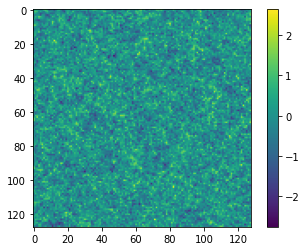

In [20]:
θ_target = np.array([0.7, 0.8])

rng, key = jax.random.split(rng)
δ_target = simulator(key, θ_target, simulator_args=simulator_args)
plt.imshow(δ_target)
plt.colorbar();

We can now define our prior distribution (in this case a uniform distribution over $A$ and $B$) with values between 0.1 and 1.25 for both parameters

In [21]:
prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.1, 0.1], [1.25, 1.25])])
prior.low = np.array([0.1, 0.1])
prior.high = np.array([1.25, 1.25])

To evaluate the likelihood of this field we can now use (dividing the target $\delta$ by $N$ to remove added scaling)

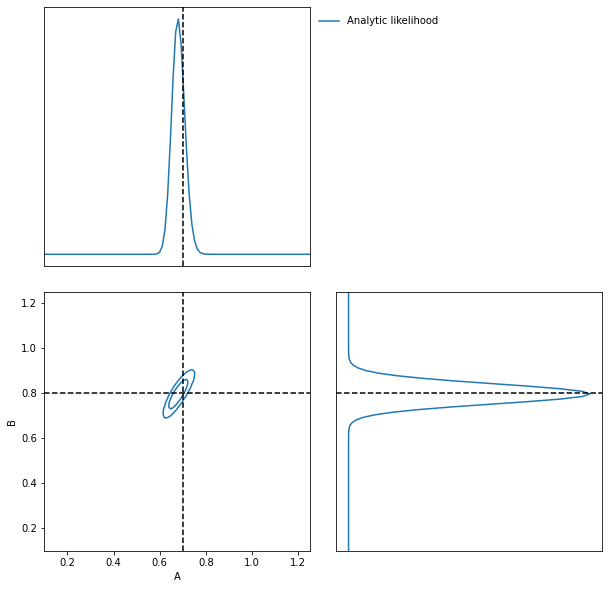

In [22]:
LFI = imnn.lfi.LikelihoodFreeInference(
    prior=prior,
    gridsize=100)
A, B = np.meshgrid(*LFI.ranges)
LFI.n_targets=1
LFI.put_marginals(
        jax.nn.softmax(
            np.real(
                log_likelihood(
                    k, 
                    A.ravel(), 
                    B.ravel(), 
                    np.fft.fftn(δ_target / N), 
                    N)
                ),axis=0
            ).reshape((100, 100)).T[np.newaxis]);
LFI.marginal_plot(
    known=θ_target,          
    label="Analytic likelihood",           
    axis_labels=["A", "B"]);

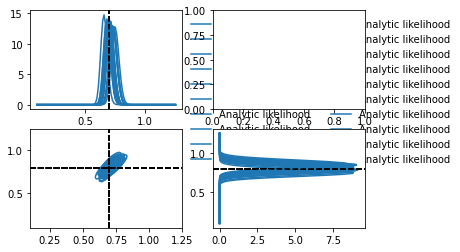

In [18]:
# sanity check:
fig,ax = plt.subplots(2,2)

for i in range(20):
    θ_target = np.array([0.7, 0.8])

    rng, key = jax.random.split(rng)
    δ_target = simulator(key, θ_target, simulator_args=simulator_args)


    LFI = imnn.lfi.LikelihoodFreeInference(
        prior=prior,
        gridsize=100)
    A, B = np.meshgrid(*LFI.ranges)
    LFI.n_targets=1
    LFI.put_marginals(
        jax.nn.softmax(
            np.real(
                log_likelihood(
                    k, 
                    A.ravel(), 
                    B.ravel(), 
                    np.fft.fftn(δ_target / N), 
                    N)
                ), axis=0).reshape((100, 100)).T[np.newaxis]);
    ax = LFI.marginal_plot(
        ax=ax,
        known=θ_target,          
        label="Analytic likelihood",           
        axis_labels=["A", "B"]);
    
plt.show()

## Training an IMNN

Now lets train an IMNN to summaries such Gaussian random fields to see how much information we can extract an what sort of constraints we can get. We will use 5000 simulations to estimate the covariance and use all of their derivatives and we'll summarise the whole random Gaussian field by 2 summaries.

In [19]:
n_s = 5000
n_d = n_s

n_summaries = 2

We're going to use a fully convolutional inception network built using stax with some custom designed blocks. The inception block itself is implemented as

In [20]:
def InceptBlock(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    conv1x1 = stax.serial(stax.Conv(filters1, (1, 1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1, 1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3, 3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1, 1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5, 5), strides, padding="SAME")) 
    
    maxpool = stax.serial(stax.MaxPool((3, 3), padding="SAME"),
                         stax.Conv(filters4, (1, 1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
    else:
        return stax.serial(
              stax.FanOut(2),
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)

We'll also want to make sure that the output of the network is the correct shape, for which we'll introduce a Reshaping layer

In [21]:
def Reshape(shape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (shape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs, shape)
    return init_fun, apply_fun

Now we can build the network, with kernel sizes of 4 in each direction in each layer

In [22]:
fs = 64

model = stax.serial(
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(4, 4)),
        InceptBlock((fs, fs, fs), strides=(2, 2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1, 1), strides=(1, 1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,)))

We'll also grab an adam optimiser from jax.experimental.optimizers

In [23]:
optimiser = optimizers.adam(step_size=1e-3)

Note that due to the form of the network we'll want to have simulations that have a "channel" dimension, which we can set up by not allowing for squeezing in the simulator.

### Initialise IMNN

Finally we can initialise the IMNN, letting the IMNN module decide what type of IMNN subclass will be used (we'll be using SimulatorIMNN)

In [29]:
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1, 1) + shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=key,
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={
                **simulator_args, 
                **{"squeeze": False}}))

`simulator` provided, using SimulatorIMNN


And finally we can fit the IMNN (we'll use generic regularisation parameters of $\lambda=10$ and $\epsilon=0.1$) and allow early stopping to determine the end of fitting.

In [30]:
%%time
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=500, best=True)

CPU times: user 13min 48s, sys: 6.06 s, total: 13min 54s
Wall time: 14min 2s


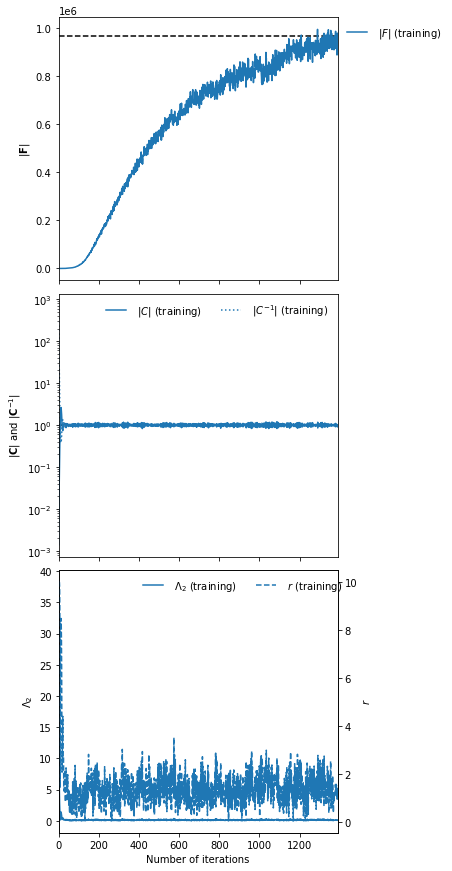

In [31]:
IMNN.plot(expected_detF=np.linalg.det(F));

In [32]:
np.linalg.det(IMNN.F) / np.linalg.det(F)

DeviceArray(0.97123594, dtype=float64)

In [33]:
np.linalg.det(F)

DeviceArray(967560.53213307, dtype=float64)

## Inference

We can now attempt to do inference of some target data using the IMNN. The first thing we should do is make a Gaussian approximation using a parameter estimate from the IMNN and the Fisher information reached at the end of fitting. Note that since the fiducial parameter values are far from the "target" that this estimate of the Fisher information as the covariance will likely be misleading.

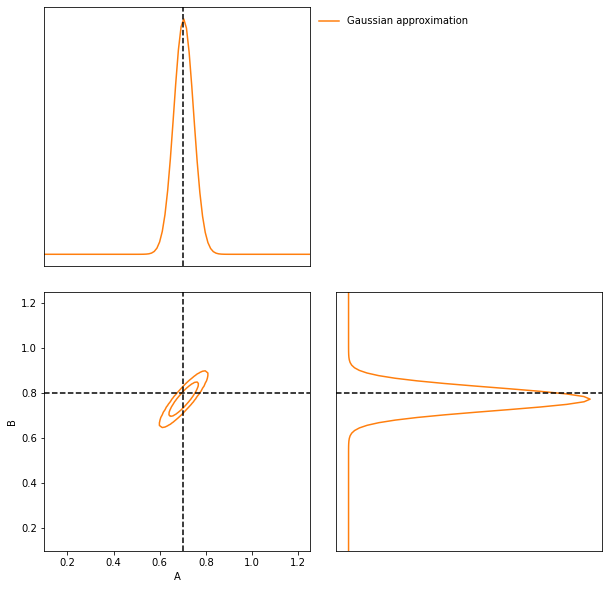

In [34]:
GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=IMNN.get_estimate(np.expand_dims(δ_target, (0, 1, 2))), 
    invF=np.expand_dims(np.linalg.inv(IMNN.F), 0), 
    prior=prior, 
    gridsize=100)
GA.marginal_plot(
    known=θ_target,          
    label="Gaussian approximation",           
    axis_labels=["A", "B"],
    colours="C1");

And finally we can do an approximate Bayesian computation

In [35]:
ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=np.expand_dims(δ_target, (0, 1, 2)),
    prior=prior,
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args={**simulator_args, **{'squeeze':False}}),
    compressor=IMNN.get_estimate,
    gridsize=100, 
    F=np.expand_dims(IMNN.F, 0))

In [36]:
rng, key = jax.random.split(rng)
ABC(ϵ=1., rng=key, n_samples=10000, min_accepted=1000, 
    smoothing=1, max_iterations=1000);

[1010] accepted in last  43 iterations  (430000 simulations done).


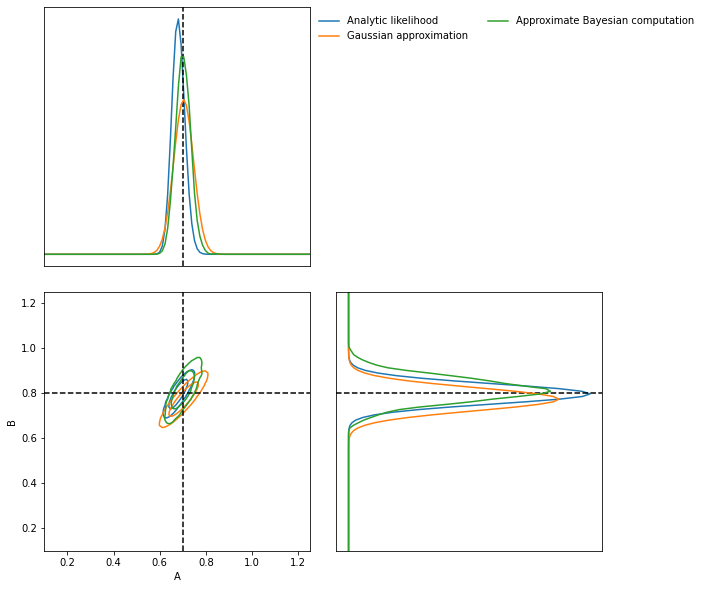

In [37]:
ax = LFI.marginal_plot(
    known=θ_target,          
    label="Analytic likelihood",           
    axis_labels=["A", "B"])


GA.marginal_plot(
    ax=ax,
    label="Gaussian approximation",
    colours="C1", 
    axis_labels=["A", "B"])


ABC.marginal_plot(
    ax=ax,
    label="Approximate Bayesian computation",
    colours="C2");

plt.show()


# iterative cosmological parameter inference of log normal fields

As a more realistic example of cosmological parameter inference from dark matter fields, albeit it one where we do not (yet) know the amount of information in the field, we can create a log normal field from a power spectrum generated with cosmological parameters.

For example lets say that our fiducial cosmology has $\Omega_c=0.80$ and $\sigma_8=0.60$, we can set

In [59]:
cosmo_params = jc.Planck15(Omega_c=0.60, sigma8=0.60)
θ_fid = np.array(
    [cosmo_params.Omega_c, 
     cosmo_params.sigma8], 
    dtype=np.float32)

Our new $P(k)$ is simply the linear matter power spectrum defined as

In [60]:
def P(k, A=0.60, B=0.60):
    cosmo_params = jc.Planck15(Omega_c=A, sigma8=B)
    return jc.power.linear_matter_power(cosmo_params, k)

In [61]:
simulator_args = dict(
    k=k,
    L=250,
    shape=shape,
    vol_norm=True,
    N_scale=False,
    squeeze=True,
    log_normal=True)

Since our lognormal field simulator *and* power spectra code are differentiable via `Jax`, we can simulate a *differentiable* universe. We'll pull out a nice function to visualize fiducial example data and its derivatives with respect to the cosmological parameters.

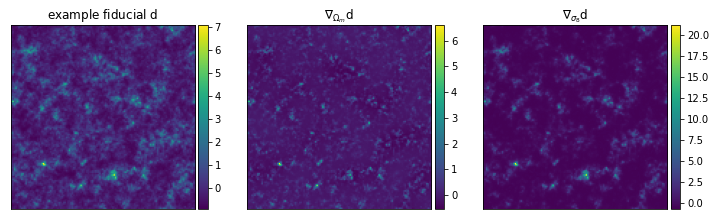

In [62]:
from imnn.utils import value_and_jacrev, value_and_jacfwd

def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, 
                                                        simulator_args=simulator_args)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(12,15))

im1 = ax[0].imshow(np.squeeze(simulation), extent=(0,1,0,1))
ax[0].title.set_text(r'example fiducial $\rm d$')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[1].imshow(np.squeeze(simulation_gradient).T[0].T, extent=(0,1,0,1))
ax[1].title.set_text(r'$\nabla_{\Omega_m} \rm d$')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[2].imshow(np.squeeze(simulation_gradient).T[1].T, extent=(0,1,0,1))
ax[2].title.set_text(r'$\nabla_{\sigma_8} \rm d$')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
plt.show()

We'll now make four target universes that we observe a little more realistic with $\Omega_c=0.25$ and $\sigma_8=0.81$ (true Planck parameters).

In [63]:
rng,key = jax.random.split(rng)

In [64]:
key

array([ 615925444, 2375634444], dtype=uint32)

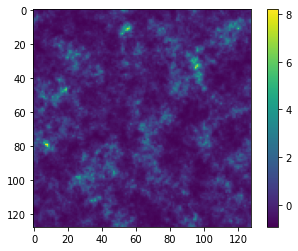

In [82]:
θ_target = np.array([jc.Planck15().Omega_c, jc.Planck15().sigma8,])

# generate four realizations
keys = jax.random.split(rng, num=4)
δ_targets = [simulator(
    k, θ_target, simulator_args=simulator_args, 
    ) for k in keys
           ]

for i,t in enumerate(δ_targets):
    np.save('./cosmo-data/target_field_planck_%d'%(i+1), t)

plt.imshow(δ_targets[-1])
plt.colorbar();

In [83]:
# load desired target data to perform iterative scheme on:
δ_target = np.load('./cosmo-data/target_field_planck_2.npy')

We can now train an IMNN as before on the fiducial model. Once we have the fiducial model trained, we'll get the Fisher estimates on the targets and then retrain closer to the target data.

In [65]:
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1, 1) + shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=key,
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={**simulator_args, **{"squeeze": False}}))

`simulator` provided, using SimulatorIMNN


In [66]:
%%time
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=500, best=False)

CPU times: user 16min 29s, sys: 4min 7s, total: 20min 36s
Wall time: 20min 29s


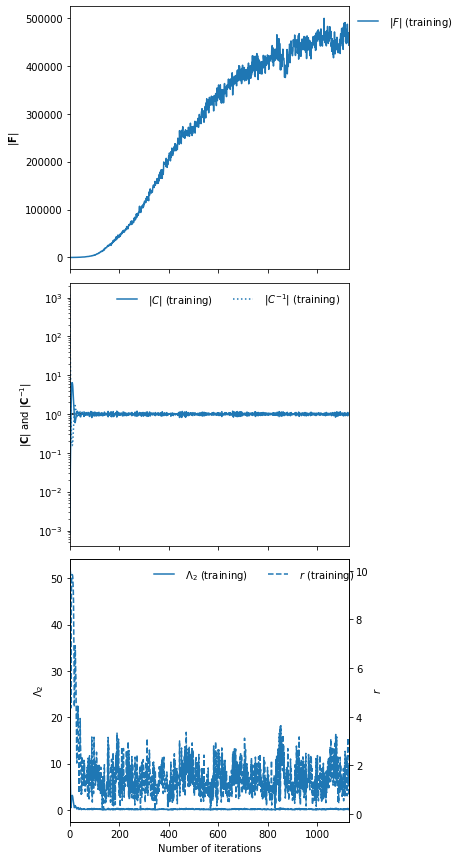

In [67]:
IMNN.plot(expected_detF=None);

And finally we can do our inference. We'll first set the prior distribution

In [84]:
prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip([0., 0.], [1.5, 1.5])])
prior.low = np.array([0., 0.])
prior.high = np.array([1.5, 1.5])

And make the Gaussian approximation using the Fisher information

In [85]:
# get estimates
estimates = [IMNN.get_estimate(np.expand_dims(targ, (0, 1, 2))) for targ in δ_targets]

In [86]:
estimates

[DeviceArray([[0.13765335, 0.7829361 ]], dtype=float32),
 DeviceArray([[-0.15481389,  0.9271127 ]], dtype=float32),
 DeviceArray([[0.09945673, 0.8058984 ]], dtype=float32),
 DeviceArray([[0.13919553, 0.80707866]], dtype=float32)]

In [87]:
GAs = [imnn.lfi.GaussianApproximation(
    parameter_estimates=estimate, 
    invF=np.expand_dims(np.linalg.inv(IMNN.F), 0), 
    prior=prior, 
    gridsize=100)
      for estimate in estimates
     ]

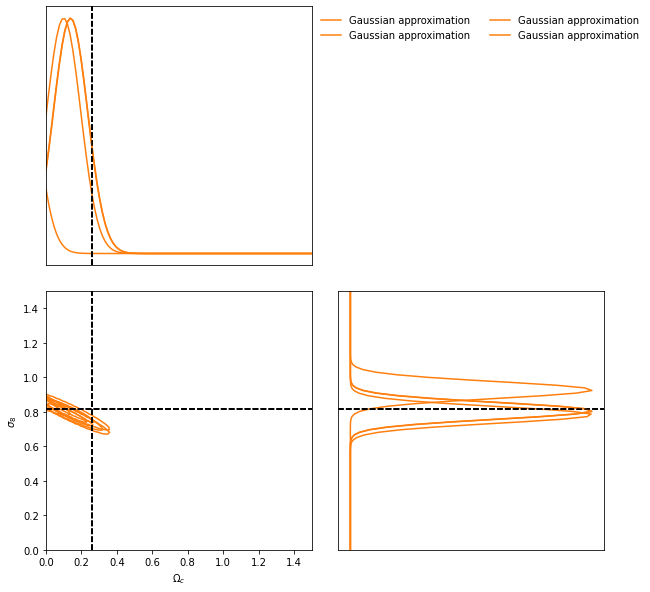

In [88]:
for g,GA in enumerate(GAs):
    if g==0:
        ax = GA.marginal_plot(
            known=θ_target,          
            label="Gaussian approximation",         
            axis_labels=[r"$\Omega_c$", r"$\sigma_8$"],
            colours="C1")
        
    else:
        GA.marginal_plot(ax=ax,
            known=θ_target,          
            label="Gaussian approximation",         
            axis_labels=[r"$\Omega_c$", r"$\sigma_8$"],
            colours="C1")

In [89]:
np.mean(np.array(estimates), axis=0)

DeviceArray([[0.05537293, 0.8307565 ]], dtype=float32)

We notice that the target data is very far away from the fiducial, so we retrain the IMNN on the estimates:

In [90]:
# save IMNN fisher
F_IMNN_1 = IMNN.F
invF_IMNN_1 = IMNN.invF

In [94]:
θ_fid_new = np.squeeze(np.mean(np.array(estimates, dtype='float32'), axis=0))

In [95]:
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=(1, 1) + shape,
        θ_fid=θ_fid_new,
        model=model,
        optimiser=optimiser,
        key_or_state=key,
        simulator=lambda rng, θ: simulator(
            rng, θ, simulator_args={**simulator_args, **{"squeeze": False}}))

`simulator` provided, using SimulatorIMNN


In [96]:
%%time
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=500, best=False)

CPU times: user 9min 37s, sys: 2min 20s, total: 11min 57s
Wall time: 11min 46s


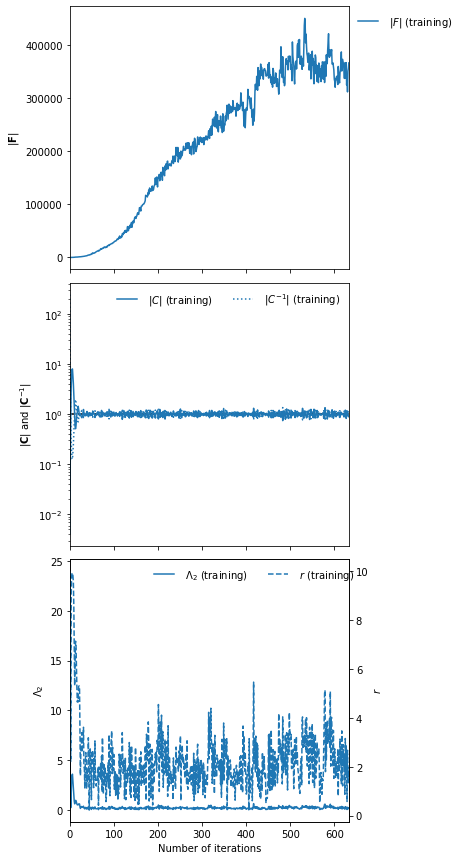

In [97]:
IMNN.plot(expected_detF=None);

DeviceArray([[1117.8125, 2101.6882],
             [2101.6882, 4374.2505]], dtype=float32)

In [383]:
print('det F IMNN 1: ', np.linalg.det(F_IMNN_1))
print('det F IMNN 2: ', np.linalg.det(IMNN.F))

det F IMNN 1:  472498.66
det F IMNN 2:  350366.88


re-do GA estimates, and then run the ABC

In [99]:
new_estimates = [IMNN.get_estimate(np.expand_dims(targ, (0, 1, 2))) for targ in δ_targets]

In [100]:
new_estimates

[DeviceArray([[0.21095073, 0.769929  ]], dtype=float32),
 DeviceArray([[0.14753437, 0.904973  ]], dtype=float32),
 DeviceArray([[0.14973399, 0.88128847]], dtype=float32),
 DeviceArray([[0.2003415, 0.8935063]], dtype=float32)]

In [101]:
GAs_new = [imnn.lfi.GaussianApproximation(
    parameter_estimates=estimate, 
    invF=np.expand_dims(np.linalg.inv(IMNN.F), 0), 
    prior=prior, 
    gridsize=100)
      for estimate in new_estimates
     ]

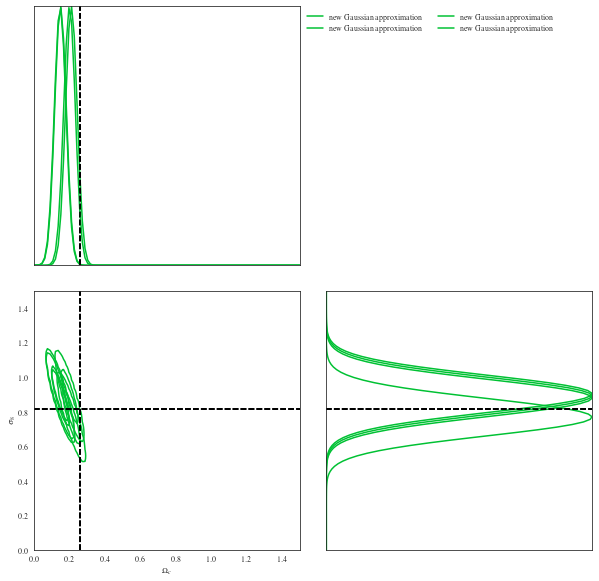

In [182]:
for g,GA in enumerate(GAs_new):
    if g==0:
        ax = GA.marginal_plot(
    known=θ_target,          
    label="new Gaussian approximation",         
    axis_labels=[r"$\Omega_c$", r"$\sigma_8$"],
    colours='#00c133')
        
    else:
        GA.marginal_plot(ax=ax,
            known=θ_target,          
            label="new Gaussian approximation",         
            axis_labels=[r"$\Omega_c$", r"$\sigma_8$"],
            colours='#00c133')

In [129]:
np.concatenate([np.expand_dims(targ, (0, 1, 2)) for targ in δ_targets], axis=2).shape

(1, 1, 4, 128, 128)

In [393]:
ABCs = [imnn.lfi.ApproximateBayesianComputation(
    target_data=np.expand_dims(targ, (0, 1, 2)),
    prior=prior,
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args={**simulator_args, **{'squeeze':False}}),
    compressor=IMNN.get_estimate,
    gridsize=100, 
    F=np.expand_dims(IMNN.F, 0)) for targ in δ_targets]

In [ ]:
%%time
for ABC in ABCs:
    rng, key = jax.random.split(rng)
    ABC(ϵ=0.05, rng=key, n_samples=10000, min_accepted=900, 
        smoothing=1., max_iterations=5000);

[558] accepted in last  5000 iterations  (50000000 simulations done).
[540] accepted in last  5000 iterations  (50000000 simulations done).


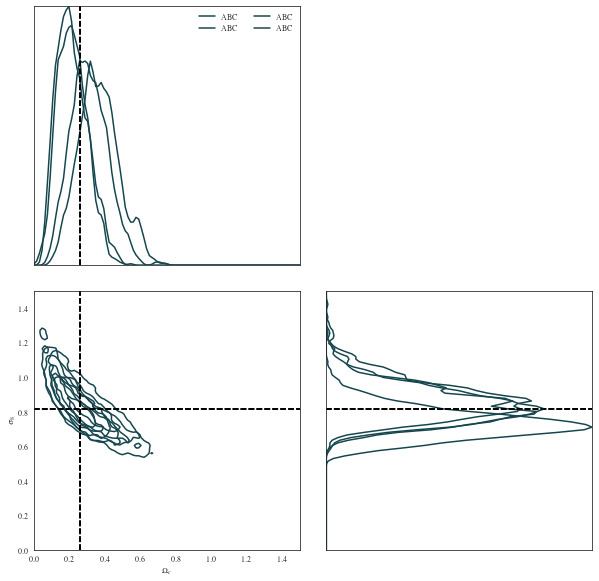

In [390]:
for g,ABC in enumerate(ABCs):
    if g==0:
        ax = ABC.marginal_plot(
    known=θ_target,          
    label="ABC",         
    axis_labels=[r"$\Omega_c$", r"$\sigma_8$"],
    colours="C1")
        
    else:
        ABC.marginal_plot(ax=ax,
            known=θ_target,          
            label="ABC",         
            axis_labels=[r"$\Omega_c$", r"$\sigma_8$"],
            colours="C1")

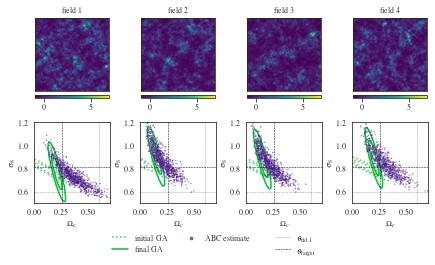

In [392]:
# make fancy plot with all the target data and scatter plot
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']

fig,ax = plt.subplots(nrows=2, ncols=4, figsize=(7.058, 3.41*1.)) 
                     # gridspec_kw={'height_ratios': [1, 1], 'width_ratios':[1,1]})

latexify(3.41*2)

for t,targ in enumerate(δ_targets):
    ABC = ABCs[t]
    GA_new  = GAs_new[t]
    GA_1  = GAs[t]
    

    
    # target image data
    if t==0:
        im = ax[0, t].imshow(np.squeeze(targ), 
                             cmap='viridis', 
                             #vmin=0, vmax=6, 
                             interpolation='spline16')
    else:
        ax[0, t].imshow(np.squeeze(targ), 
                             cmap='viridis', 
                             #vmin=0, vmax=6, 
                             interpolation='spline16')
    
    ax[0, t].set_xticks([])
    ax[0, t].set_yticks([])
    
    
    divider = make_axes_locatable(ax[0, t])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='horizontal')
    
    # params for GA contour
    row=1
    column=0
    target=0
    levels=[0.68, 0.95]
    all_margs = [GA.marginals for GA in [GA_1, GA_new]]
    alphas = [0.75, 1.0]
    linestyles = [':', 'solid']
    GA_labels = ['initial GA', 'final GA']
    ga_handles = []
    
    for m,margs in enumerate(all_margs):
        cs = ax[1,t].contour(
                                ranges[column],
                                ranges[row],
                                margs[row][column][target].T,
                                colors='#00c133',
                                linestyles=linestyles[m],
                                levels=GA_new.get_levels(
                                    margs[row][column][target],
                                    [ranges[column], ranges[row]],
                                    levels=levels), alpha=alphas[m],
        )
        # proxy for legend
        _ga, = ax[1,t].plot(-1,2, color='#00c133', 
                     linestyle=linestyles[m], 
                     alpha=alphas[m],label=GA_labels[m])
        
        ga_handles.append(_ga)

    
    # add ABC scatter plot by ABC distance
    
    ax[1,t].scatter(ABC.parameters.accepted[0][:, 0], ABC.parameters.accepted[0][:, 1], s=8, alpha=0.6,
                c=np.log(ABC.distances.accepted[0]), cmap='Purples', edgecolors=None, linewidths=0, marker='.', zorder=10)
    
    abc_handle = ax[1,t].scatter(-1, -2, s=8, alpha=0.6, color='purple', label='ABC estimate')
    
    ax[1,t].axvline(θ_target[0], linestyle='--', c='k', linewidth=0.5)
    target_handle = ax[1,t].axhline(θ_target[1], linestyle='--', c='k', linewidth=0.5, label=r'$\theta_{\rm target}$')
    
    
    ax[1,t].axvline(θ_fid[0], linestyle='--', c='k', linewidth=0.5, alpha=0.4)
    fid_handle = ax[1,t].axhline(θ_fid[1], linestyle='--', c='k', linewidth=0.5, alpha=0.4, label=r'$\theta_{\rm fid, 1}$')

        
    
    ax[1,t].set_xlabel(r'$\Omega_c$')
    ax[1,t].set_ylabel(r'$\sigma_8$')
    
    ax[1,t].set_xlim(0., 0.7)
    ax[1,t].set_ylim(0.5, 1.2)
    
    ax[0, t].set_title('field %d'%(t+1))
    
#print(len(ga_handles[0][0]))


ax[1,2].legend(handles=[ga_handles[0], ga_handles[1], abc_handle], 
               framealpha=0., bbox_to_anchor=(0.15, -0.3), frameon=False, ncol=2)

ax[1, 3].legend(handles=[fid_handle, target_handle], 
                framealpha=0., bbox_to_anchor=(-0.4, -0.3), frameon=False, ncol=1)

    
#plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig('/mnt/home/tmakinen/repositories/field-plots/cosmo-ln-4-plot-2.png', dpi=900, bbox_inches='tight')


In [308]:
ax2

<AxesSubplot:xlabel='$\\Omega_c$', ylabel='$\\sigma_8$'>

In [ ]:
%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
#fig = plt.figure(constrained_layout=True, figsize=(3.41*1., 3.41*1.))
#fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
#ax = fig.subplots(nrows=2, ncols=2)
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.41*1., 3.41*1.), 
                      gridspec_kw={'height_ratios': [1, 1], 'width_ratios':[1,1]})
latexify(fig_width=3.41, fig_height=3.41)

# just to fiddle with the label
ax[0,0].plot(0.3, 0., color=new_colors[0],
           marker='o', label='ABC')

cmap_reversed = matplotlib.cm.get_cmap('viridis_r')



ax = GAs[0].marginal_plot(ax=ax, colours='#00c133', #new_colors[1], 
                          axis_labels=[r"$A$", r"$B$"], label="Gaussian Approximation", ncol=1,
                            linestyle='dotted')
ax[0,0].legend(framealpha=0.)
ax[0,1].imshow(np.squeeze(target_data), cmap='viridis')


ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$A$')
ax[1,0].set_ylabel(r'$B$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

ax[1,1].legend(framealpha=0.)


# add in the likelihood estimate
ax[0, 0].plot(A_range, likelihoodA, color='#FF8D33', label='Analytic Likelihood', linestyle='--')
#ax[0,0].legend(framealpha=0.)
ax[0, 1].axis("off")
ax[1, 0].contour(A_range, B_range, likelihood, levels=value, colors='#FF8D33', linestyles='--')
ax[1, 1].plot(likelihoodB, B_range, color='#FF8D33', label='Analytic Likelihood', linestyle='--')

# ax = ABC.scatter_plot(ax=ax,
#                       colours=new_colors[0], 
#                       axis_labels=[r"$A$", r"$B$"], 
#                       s=8,
#                       label='ABC', bbox_to_anchor=None)

# ABC scatter plots
ax[0,0].hist(ABC.parameters.accepted[0][:, 0], color=new_colors[0], histtype='step', density=True)
ax[1,0].scatter(ABC.parameters.accepted[0][:, 0], ABC.parameters.accepted[0][:, 1], s=8, alpha=0.6,
                c=np.log(ABC.distances.accepted[0]), cmap='Purples', edgecolors=None, linewidths=0, marker='.')

ax[1,1].hist(ABC.parameters.accepted[0][:, 1], color=new_colors[0], 
             histtype='step', density=True, orientation='horizontal')


#ax[1,0].legend(framealpha=0.)



ax[0,0].set_xlim(0.55, 1.1)
#ax[0,0].set_ylim(0., 10.1)
ax[1,0].set_xlim(0.55, 1.1)
ax[1,0].set_ylim(0.3, 0.9)
ax[1,1].set_ylim(0.3, 0.9)

ax[0,0].legend(framealpha=0., bbox_to_anchor=(1.08, 1.5), frameon=False)


ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

#ax[0,0].set_ylabel(r'$\mathit{P}(A|\textbf{x})$')
#ax[1,1].set_xlabel(r'$\mathit{P}(B|\textbf{x})$')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()

#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-inference-contours-3sig-nolab-col.png', dpi=400, bbox_inches='tight')
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

And then we can plot the constraints obtained using the IMNN and LFI

In [137]:
# Create figures in Python that handle LaTeX, and save images to files in my
# preferred formatting. I typically place this code in the root of each of my
# projects, and import using:
# from latexify import *
# which will also run the latexify() function on the import.

# Based on code from https://nipunbatra.github.io/blog/2014/latexify.html

import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

#Back-end to use depends on the system
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
# matplotlib.use('pgf')
# from matplotlib.backends.backend_pgf import FigureCanvasPgf
# matplotlib.backend_bases.register_backend('ps', FigureCanvasPgf)

import seaborn as sns
sns.set_style("white")

#my preferred palette. From
#https://seaborn.pydata.org/tutorial/color_palettes.html: "The cubehelix color
#palette system makes sequential palettes with a linear increase or decrease in
#brightness and some variation in hue. This means that the information in your
#colormap will be preserved when converted to black and white (for printing) or
#when viewed by a colorblind individual."

# I typically set the number of colors (below, 8) to the distinct colors I need
# in a given plot, so as to use the full range.
sns.set_palette(sns.color_palette("cubehelix", 8))


# The following is the latexify function. It allows you to create 2 column or 1
# column figures. You may also wish to alter the height or width of the figure.
# The default settings are good for most cases. You may also change the
# parameters such as labelsize and fontsize based on your classfile.
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1, 2])

    if fig_width is None:
        fig_width = 6.9 if columns == 1 else 13.8  # width in inches #3.39

    if fig_height is None:
        golden_mean = (sqrt(5) - 1.0) / 2.0    # Aesthetic ratio
        fig_height = fig_width * golden_mean  # height in inches

    MAX_HEIGHT_INCHES = 16.0
    if fig_height > MAX_HEIGHT_INCHES:
        print(("WARNING: fig_height too large:" + fig_height +
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches."))
        fig_height = MAX_HEIGHT_INCHES

    params = {
            # 'backend': 'ps',
           #   'pgf.rcfonts': False,
           #   'pgf.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
           #   "pgf.texsystem": "pdflatex",
             # 'text.latex.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
              'text.latex.preamble': '\\usepackage{mathptmx}',
              #values below are useful defaults. individual plot fontsizes are
              #modified as necessary.
              'axes.labelsize': 8,  # fontsize for x and y labels
              'axes.titlesize': 8,
              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'font.serif': 'Times',
               'lines.linewidth': 1.5,
               'lines.markersize':1,
               'xtick.major.pad' : 2,
               'ytick.major.pad' : 2,
                'axes.xmargin' :  .0,  # x margin.  See `axes.Axes.margins`
                'axes.ymargin' : .0,  # y margin See `axes.Axes.margins`
              }

    matplotlib.rcParams.update(params)

def saveimage(name, fig = plt, extension = 'pdf', folder = 'plots/'):
    sns.despine()

    #Minor ticks off by default in matplotlib
    # plt.minorticks_off()

    #grid being off is the default for seaborn white style, so not needed.
    # plt.grid(False, axis = "x")
    # plt.grid(False, axis = "y")
    
    fig.savefig('{}{}.{}'.format(folder,name, extension), bbox_inches = 'tight')

latexify()

In [262]:
# plot just the joint GA marginals

In [341]:
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels)
    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]